# Proyek Pertama : Membuat Model NLP dengan TensorFlow Menggunakan Dataset Coronavirus Tweets

Proyek ini bertujuan untuk membuat model untuk klasifikasi teks. Penelitian ini menggunakan Coronavirus tweets NLP - Text Classification Dataset untuk mengetahui sentimen masyarakat terhadap COVID-19 berdasarkan cuitan tweeter. Diharapkan hasil akhir proyek ini dapat membuat model klasifikasi teks yang dapat membedakan sentimen Neutral, Positif, Negatif, Sangat Positif, dan Sangat Negatif dengan akurasi yang baik.

1. Memiliki minimal 1000 sampel. Sebaiknya 2000 sampel. 
2. Menggunakan LSTM dalam arsitektur model.
3. Menggunakan model sequential.
4. Membagi dataset, Validation set sebesar 20% dari total dataset.
5. Menggunakan Embedding.
6. Menggunakan fungsi tokenizer.
7. Akurasi dari model minimal 75%. Sebaiknya > 85%.
8. Melampirkan file .py dan .ipynb, dikumpulkan dalam .zip

+ Menggunakan Callback.
+ Membuat plot loss dan akurasi pada saat training dan validation.
+ Memiliki 3 atau lebih kelas

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns

# Memperoleh Dataset

Dataset [Coronavirus tweets NLP - Text Classification](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification) dipilih karena memiliki 3798 sampel pada test set, dan 41.200 sampel pada train set. Memiliki 5 label.

In [ ]:
# Upload dataset pada colab
# Pada proyek 1 ini hanya menggunakan data dari test set karena yang diinginkan hanya minimal 1000 atau 2000 data

In [ ]:
df = pd.read_csv('Corona_NLP_test.csv')

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
df.shape

(3798, 6)

In [ ]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [ ]:
df = df.drop(columns=['UserName', 'ScreenName', 'Location', 'TweetAt'])

In [ ]:
df.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


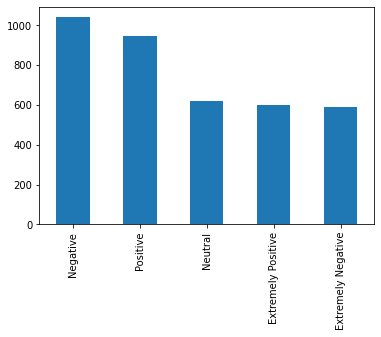

In [ ]:
df.Sentiment.value_counts().plot(kind='bar')

In [ ]:
# melakukan one-hot-encoding dan membuat dataframe baru
category = pd.get_dummies(df.Sentiment)
df1= pd.concat([df, category], axis=1)
df1 = df1.drop(columns='Sentiment')
df1.head()

,OriginalTweet,Extremely Negative,Extremely Positive,Negative,Neutral,Positive
0,TRENDING: New Yorkers encounter empty supermar...,1,0,0,0,0
1,When I couldn't find hand sanitizer at Fred Me...,0,0,0,0,1
2,Find out how you can protect yourself and love...,0,1,0,0,0
3,#Panic buying hits #NewYork City as anxious sh...,0,0,1,0,0
4,#toiletpaper #dunnypaper #coronavirus #coronav...,0,0,0,1,0


In [ ]:
df1.columns

Index(['OriginalTweet', 'Extremely Negative', 'Extremely Positive', 'Negative',
       'Neutral', 'Positive'],
      dtype='object')

In [ ]:
# Agar dapat diproses oleh model, kita perlu mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values.
X = df1['OriginalTweet'].values
y = df1[['Extremely Negative', 'Extremely Positive', 'Negative',
       'Neutral', 'Positive']].values 
X

array(['TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1',
       "When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how  #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",
       'Find out how you can protect yourself and loved ones from #coronavirus. ?',
       ...,
       "Asst Prof of Economics @cconces was on @NBCPhiladelphia talking about her recent research on coronavirus' impact on the economy. Watch it here (starting at :33): https://t.co/8tfYNoro5l",
       "Gov need to do somethings instead of biar je rakyat assume 'lockdown' ke or even worst. Harini semua supermarket crowded like hell. Lagi mudah virus tu tersebar ?? #COVID2019",
       'I and @ForestandPaper members are committed to the safety of our employe

In [ ]:
# bagi data untuk training dan data untuk testing, validation set sebesar 20%
X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.20)
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)

(3038,) (3038, 5)
(760,) (760, 5)


In [ ]:
# ubah setiap kata pada dataset kita ke dalam bilangan numerik dengan fungsi Tokenizer
# Tokenisasi bertujuan mengonversi kata-kata ke dalam bilangan numerik
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(X_train) 
tokenizer.fit_on_texts(X_valid)

In [ ]:
# Setelah tokenisasi selesai, kita perlu membuat mengonversi setiap sampel menjadi sequence
# sekuens adalah sebuah larik yang berisi kumpulan token sesuai dengan setiap kata pada sebuah kalimat dalam teks.
sekuens_train = tokenizer.texts_to_sequences(X_train)
sekuens_valid = tokenizer.texts_to_sequences(X_valid)

padded_train = pad_sequences(sekuens_train) 
padded_valid = pad_sequences(sekuens_valid)

In [ ]:
# memanggil Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
# layer Embedding, menggunakan LSTM, Sequental
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
# panggil latih fit
# menggunakan batch loading agar loading lebih cepat, batch size bisa memilih 32,64, dan 128
# mengguankan callbacks agar stop bila telah mencapai akurasi yang diinginkan
num_epochs = 30
history = model.fit(padded_train, Y_train, epochs=num_epochs, batch_size=32, callbacks=[callbacks],
                    validation_data=(padded_valid, Y_valid), verbose=2)

Epoch 1/30
95/95 - 5s - loss: 1.5777 - accuracy: 0.2709 - val_loss: 1.5250 - val_accuracy: 0.3118
Epoch 2/30
95/95 - 3s - loss: 1.4919 - accuracy: 0.3084 - val_loss: 1.4516 - val_accuracy: 0.3197
Epoch 3/30
95/95 - 3s - loss: 1.2775 - accuracy: 0.4167 - val_loss: 1.4999 - val_accuracy: 0.3368
Epoch 4/30
95/95 - 3s - loss: 1.0193 - accuracy: 0.5142 - val_loss: 1.7474 - val_accuracy: 0.3276
Epoch 5/30
95/95 - 3s - loss: 0.8471 - accuracy: 0.5829 - val_loss: 1.9942 - val_accuracy: 0.3092
Epoch 6/30
95/95 - 3s - loss: 0.6882 - accuracy: 0.6942 - val_loss: 2.0519 - val_accuracy: 0.3461
Epoch 7/30
95/95 - 3s - loss: 0.5300 - accuracy: 0.7916 - val_loss: 2.5244 - val_accuracy: 0.3474
Epoch 8/30
95/95 - 3s - loss: 0.3790 - accuracy: 0.8568 - val_loss: 2.9336 - val_accuracy: 0.3474
Epoch 9/30
95/95 - 3s - loss: 0.2224 - accuracy: 0.9276 - val_loss: 2.9417 - val_accuracy: 0.3803

Akurasi telah mencapai >90%!


In [ ]:
# Model Accuracy
accuracy = history.history["accuracy"]
loss = history.history["loss"]

val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

In [ ]:
print("Akurasi training {0}% and training loss {1}%".format(accuracy[-1]*100, loss[-1]*100))
print("Akurasi validation {0}% and validation loss {1}%".format(val_accuracy[-1]*100, val_loss[-1]*100))

Akurasi training 92.75839328765869% and training loss 22.237813472747803%
Akurasi validation 38.02631497383118% and validation loss 294.1699743270874%


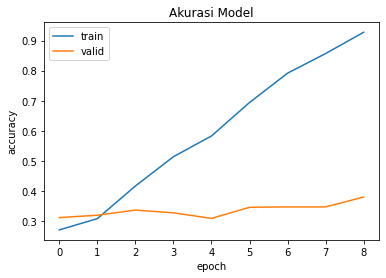

In [ ]:
#plot validasi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

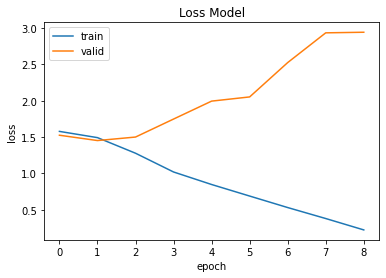

In [ ]:
#plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

Model klasifikasi teks ini telah saya upayakan mengikuti ketentuan di modul. Memiliki 5 kelas. Sampel data lebih dari 2000. Akurasi pada trainning set sudah bagus 92%, namun akurasi validasi masih kurang, yaitu 38%. karena waktu yang mepet dengan penyelesaian program FGA, saya mengumpulkan terlebih dahulu notebook ini, dengan harapan akan memperbaiki nanti setelah program berakhir. 

+ Memiliki 3 atau lebih kelas
+ Menggunakan LSTM dalam arsitektur model.
+ Menggunakan model sequential.
+ Membagi dataset, Validation set sebesar 20% dari total dataset.
+ Menggunakan Embedding.
+ Menggunakan fungsi tokenizer.
+ Akurasi dari model 90%.
+ Menggunakan Callback.
+ Membuat plot loss dan akurasi pada saat training dan validation.
+ Mencoba menerapkan dropout, tapi masih belum benar pada cell di bawah

In [ ]:
# layer Embedding, menggunakan LSTM, Sequental
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
# panggil latih fit
# menggunakan batch loading agar loading lebih cepat, batch size bisa memilih 32,64, dan 128
# mengguankan callbacks agar stop bila telah mencapai akurasi yang diinginkan
num_epochs = 30
history = model.fit(padded_train, Y_train, epochs=num_epochs, batch_size=32, callbacks=[callbacks],
                    validation_data=(padded_valid, Y_valid), verbose=2)

Epoch 1/30


ValueError: ignored

In [ ]:
#Model Accuracy
accuracy = history.history["accuracy"]
loss = history.history["loss"]

val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

In [ ]:
print("Akurasi training {0}% and training loss {1}%".format(accuracy[-1]*100, loss[-1]*100))
print("Akurasi validation {0}% and validation loss {1}%".format(val_accuracy[-1]*100, val_loss[-1]*100))

Akurasi training 90.98091125488281% and training loss 26.827087998390198%
Akurasi validation 33.68421196937561% and validation loss 416.29624366760254%


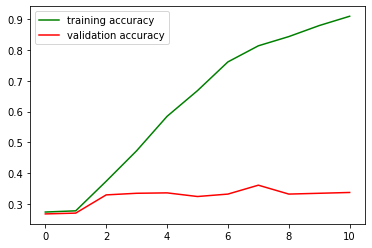

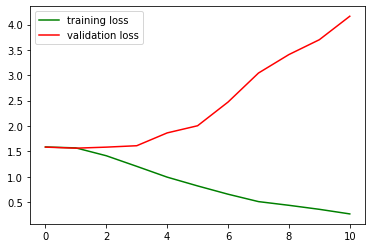

In [ ]:
#plot 

plt.plot(accuracy,'g',label='training accuracy')
plt.plot(val_accuracy, 'r', label='validation accuracy')
plt.legend()
plt.show()


plt.plot(loss,'g',label='training loss')
plt.plot(val_loss, 'r', label='validation loss')
plt.legend()
plt.show()

# Thank you for reviewing this notebook!

In [ ]:
### This Notebook written by Tsaniyah Nur Kholilah. 2021. As part of Digitalent Kominfo Scholarship Project Completion

---



---



https://www.dicoding.com/users/tsancode


Referensi:
1. Save and load models Tensorflow https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb#scrollTo=R7W5plyZ-u9X
2. Forum Diskusi Dicoding
3. Basic Clasification https://www.tensorflow.org/tutorials/keras/classification